In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error


In [6]:
df = sm.datasets.sunspots.load_pandas().data
df = df.set_index('YEAR')
df.index = pd.to_datetime(df.index, format='%Y')
df = df.asfreq('YS')

In [56]:
test_size = 80

In [57]:
y = df[:-test_size].values
fft_values = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(y))
positive_freqs = frequencies[:len(frequencies) // 2]
positive_fft_values = np.abs(fft_values[:len(fft_values) // 2])

fft_output = pd.DataFrame({
    'positive_freqs': positive_freqs.flatten(), 
    'positive_fft_values': positive_fft_values.flatten()
    }).sort_values(by='positive_fft_values', ascending=False)

top_freq = fft_output['positive_freqs'][:10].values
top_periods = 1/top_freq

time = np.arange(0, df.shape[0], 1)
fourier_terms = pd.DataFrame()
for i, period in enumerate(top_periods):
    fourier_terms[f'f_sin_{i}'] = np.sin(2*np.pi/period * time)
    fourier_terms[f'f_cos_{i}'] = np.cos(2*np.pi/period * time)

fourier_terms.index = df.index
dff = pd.concat([df, fourier_terms], axis=1)

In [58]:
df_train = dff[:-test_size]
df_test = dff[-test_size:]
print(df_test.shape, df_train.shape)

(80, 21) (229, 21)


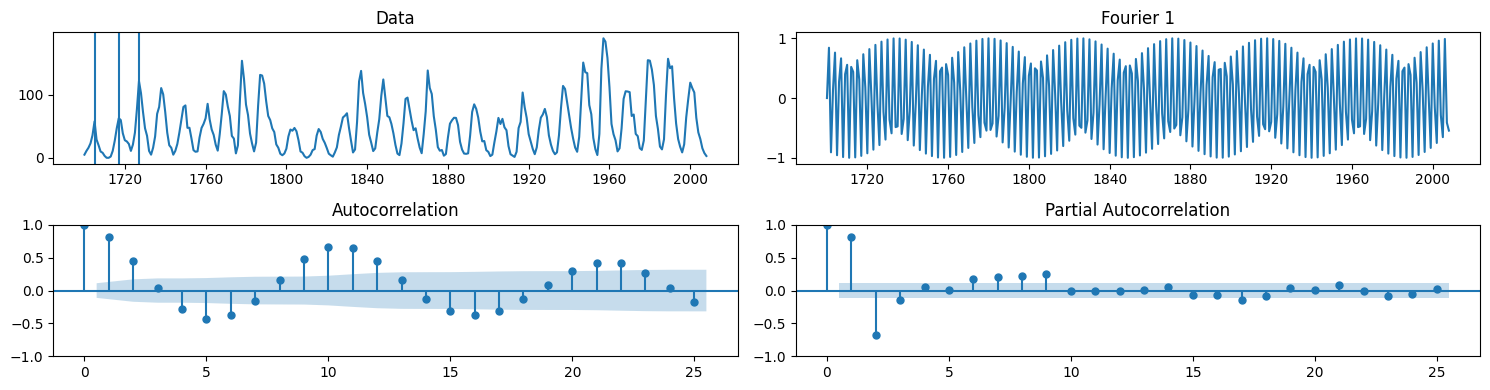

In [59]:
fig, ax = plt.subplots(2, 2, figsize=(15, 4))
ax[0, 0].plot(df)
for i in [1705, 1717, 1727]: ax[0, 0].axvline(x=pd.to_datetime(f'{i}-01-01'))
ax[0, 1].plot(dff['f_sin_0'])
sm.graphics.tsa.plot_acf(df, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(df, ax=ax[1, 1])
ax[0, 0].set_title('Data')
ax[0, 1].set_title('Fourier 1')
plt.tight_layout()
plt.show()

In [70]:
model = SARIMAX(
    endog=df_train.iloc[:, 0], 
    exog=df_train.iloc[:, 1:],
    order=(1, 1, 0), 
    seasonal_order=(0, 0, 0, 0))

model_fit = model.fit()

forecast = model_fit.get_forecast(
    steps=test_size,
    exog=df_test.iloc[:, 1:])

#print(model_fit.summary())

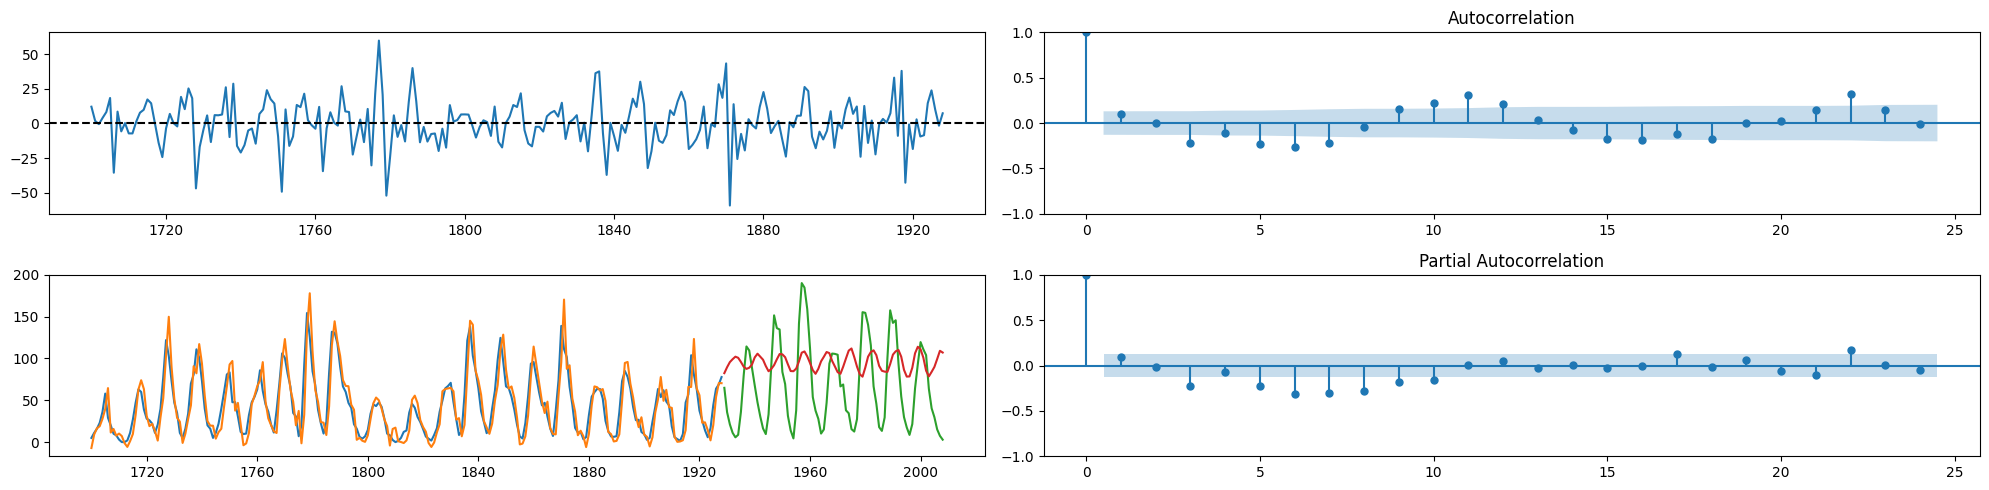

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax[0, 0].plot(model_fit.resid)
ax[0, 0].axhline(y=0, linestyle='--', color='black')
sm.graphics.tsa.plot_acf(model_fit.resid, ax=ax[0, 1])
sm.graphics.tsa.plot_pacf(model_fit.resid, ax=ax[1, 1])
ax[1,0].plot(df_train.iloc[:, 0])
ax[1,0].plot(model_fit.fittedvalues)

ax[1,0].plot(df_test.iloc[:, 0])

ax[1, 0].plot(forecast.predicted_mean)
plt.tight_layout()
plt.show()


### **Train and test on expanding window**

In [52]:
order= (2, 0, 0)
seasonal_order = (1, 0, 0, 10)

initial_train_size = 200
test_size = 15

mse = list()

for end_of_train_set in range(initial_train_size, len(df) - test_size):
    
    start_of_test_set = end_of_train_set
    end_of_test_set = start_of_test_set + test_size

    df_train = df[:end_of_train_set]
    df_test = df[end_of_train_set:(end_of_train_set + test_size)]

    model = SARIMAX(
        endog=df_train, 
        order=(2, 0, 0), 
        seasonal_order=(1, 0, 0, 10))
    model_fit = model.fit()


    forecast = model_fit.forecast(steps=test_size)
    
    mse.append(root_mean_squared_error(df_test, forecast))

In [53]:

# model diagnostics: 
# autocorrelation of residuals -> Ljung-Box should be non-sig
# normality of residuals -> jarque-bera should be non-sig, skewness ~0, kurtosis ~3
# heteroskedasticity of residuals -> H should be non-sig.
#print(model_fit.summary())

forecast_transformed = model_fit.get_prediction(
    start=df_transformed_test.index[0],
    end=df_transformed_test.index[-1],
    dynamic=True,
)

#forecast_transformed = model_fit.forecast(df_transformed_train.values[-model_fit.k_ar:], steps=n_forecast)

forecast = 10.0**forecast_transformed.predicted_mean - 1

fig, ax = plt.subplots(2, 2, figsize=(20, 5))
ax[0, 0].plot(model_fit.resid)
ax[0, 0].axhline(y=0, linestyle='--', color='black')
sm.graphics.tsa.plot_acf(model_fit.resid, ax=ax[0, 1])
sm.graphics.tsa.plot_pacf(model_fit.resid, ax=ax[1, 1])
ax[1,0].plot(df_train)
ax[1, 0].plot(10.0**model_fit.fittedvalues - 1)
ax[1,0].plot(df_test)
ax[1, 0].plot(forecast)
plt.tight_layout()
plt.show()


NameError: name 'df_transformed_test' is not defined